In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.stats import mode


Image Classification using K - means (Hard - coded)

In [2]:
PATH = os.path.join("..", "content", "mnist-original.mat")

In [3]:
CLUSTERS = 856
EPOCHS = 10
IMG_SIZE = 28
LIMITING_PER = 0.95
SAMPLES = 60000

In [4]:
mnist = loadmat(PATH)
mnist_data, mnist_label = np.array(mnist["data"].T), np.array(mnist["label"].T)
train_mnist_data, test_mnist_data = mnist_data[:SAMPLES], mnist_data[SAMPLES:]
train_mnist_label, test_mnist_label = mnist_label[:SAMPLES], mnist_label[SAMPLES:]

In [5]:
def euclidean_distance(a, b):
    """
    Calculate the Euclidean distance between two points.
    Parameters:
        a (np.ndarray): First point.
        b (np.ndarray): Second point.
    Returns:
        float: Euclidean distance between points a and b.
    """
    return np.linalg.norm(a - b)

In [6]:
def pca(X, variance_threshold=LIMITING_PER if LIMITING_PER <= 1 else LIMITING_PER / 100):
    """
    Perform PCA on data X and return the projected data with enough principal components
    to explain at least 95% of the variance.

    Parameters:
        X (np.ndarray): Data matrix of shape (n_samples, n_features)

    Returns:
        X_pca (np.ndarray): Projected data with selected principal components
        components (np.ndarray): Principal axes (eigenvectors)
        explained_variance_ratio (np.ndarray): Explained variance ratio of selected components
    """

    mean = np.mean(X, axis=0)
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)

    sorted_idx = np.argsort(eigvals)[::-1]
    
    eigvals = eigvals[sorted_idx]
    eigvecs = eigvecs[:, sorted_idx]

    explained_variance_ratio = eigvals / np.sum(eigvals)
    cumulative_variance = np.cumsum(explained_variance_ratio)

    num_components = np.searchsorted(cumulative_variance, variance_threshold) + 1

    components = eigvecs[:, :num_components]
    X_pca = np.dot(X_centered, components)

    return X_pca, mean, components, explained_variance_ratio[:num_components]

In [7]:
def k_means(X, n_clusters=CLUSTERS, n_epochs=EPOCHS):
    """
    Perform K-Means clustering on data X.

    Parameters:
        X (np.ndarray): Data matrix of shape (n_samples, n_features)
        n_clusters (int): Number of clusters
        n_epochs (int): Number of iterations
    Returns:
        centroids (np.ndarray): Final centroids of shape (n_clusters, n_features)
        labels (np.ndarray): Cluster assignments for each data point of shape (n_samples,)
    """

    n_samples, n_features = X.shape
    random_indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X[random_indices]

    for epoch in range(n_epochs):
        print(f"K-Means Epoch {epoch + 1} / {n_epochs}")
        labels = np.zeros(n_samples, dtype=int)

        for i in range(n_samples):
            distances = np.array([euclidean_distance(X[i], centroid) for centroid in centroids])
            labels[i] = np.argmin(distances)

        new_centroids = np.zeros((n_clusters, n_features))
        for k in range(n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[k] = centroids[k]

        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids, labels

In [8]:
def construct_clusters(X, centroids):
    """
    Assign each sample in X to the nearest centroid using Euclidean distance.

    Parameters:
        X (np.ndarray): Data matrix of shape (n_samples, n_features)
        centroids (np.ndarray): Centroids of shape (n_clusters, n_features)

    Returns:
        labels (np.ndarray): Cluster assignments for each data point (n_samples,)
    """
    n_samples = X.shape[0]
    labels = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        labels[i] = np.argmin(distances)
    return labels

In [9]:
X_pca, X_mean, components, explained_variance_ratio = pca(train_mnist_data)
centroids, labels = k_means(X_pca)
centroids_reconstructed = np.dot(centroids, components.T) + X_mean


K-Means Epoch 1 / 10
K-Means Epoch 2 / 10
K-Means Epoch 3 / 10
K-Means Epoch 4 / 10
K-Means Epoch 5 / 10
K-Means Epoch 6 / 10
K-Means Epoch 7 / 10
K-Means Epoch 8 / 10
K-Means Epoch 9 / 10
K-Means Epoch 10 / 10


In [10]:
clustered_images = [train_mnist_data[labels == i] for i in range(CLUSTERS)]

C:\Users\Reon\AppData\Local\Temp\ipykernel_33588\1884797099.py:6: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


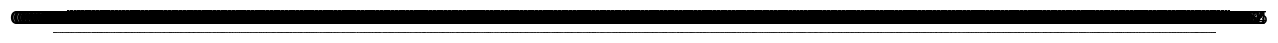

In [11]:
fig, axes = plt.subplots(1, len(centroids_reconstructed), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(centroids_reconstructed[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.set_title(f"Centroid {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'

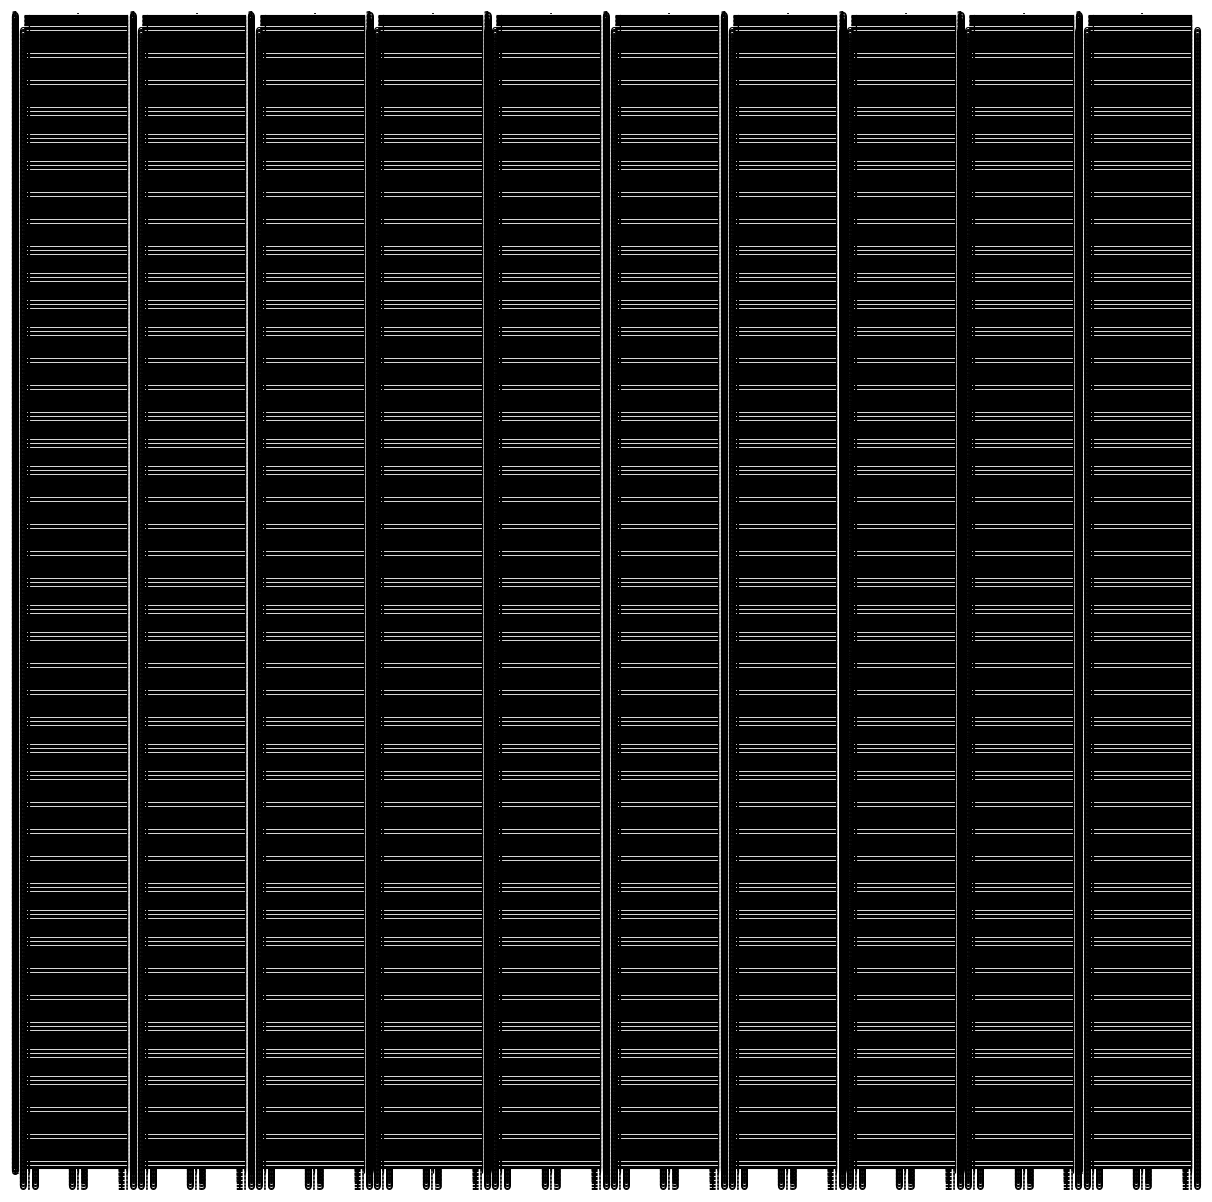

In [12]:
samples_per_cluster = 10
fig, axes = plt.subplots(CLUSTERS, samples_per_cluster, figsize=(15, 15))

test_labels = construct_clusters(test_mnist_data, centroids_reconstructed)

for cluster in range(CLUSTERS):
    cluster_indices = np.random.choice(np.where(test_labels == cluster)[0], samples_per_cluster, replace=False)
    for j, idx in enumerate(cluster_indices):
        axes[cluster, j].imshow(test_mnist_data[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        axes[cluster, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
true_labels = train_mnist_label.flatten().astype(int)

predicted_labels = np.zeros_like(labels)
for k in range(CLUSTERS):
    mask = (labels == k)
    if np.any(mask):
        predicted_labels[mask] = mode(true_labels[mask], keepdims=True)[0]

accuracy = np.mean(predicted_labels == true_labels)
print(f"Clustering accuracy: {100 * accuracy:.4f} %")

Clustering accuracy: 59.3983 %
